# part0: imports

In [1]:
import os, sys, pathlib
from pprint import pprint
import gc
import pickle
from importlib import reload
import logging, warnings
logging.basicConfig(level=logging.WARNING)

import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import PCA
import scipy.linalg as linalg
from scipy.stats import pearsonr

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from matplotlib.ticker import MaxNLocator
from matplotlib.collections import LineCollection
%matplotlib inline


import pyaldata as pyal

try:
    nbPath = pathlib.Path.cwd()
    RepoPath = nbPath.parent
    os.chdir(RepoPath)

    from tools import utilityTools as utility
    from tools import dataTools as dt
    import params
    defs = params.monkey_defs
    
    set_rc =  params.set_rc_params
    set_rc()
    root = params.root

finally:
    os.chdir(nbPath)

if "__file__" not in dir():
    %run "_dataset-selection.ipynb"

the variable `GoodDataList` contains the session names




load the data

In [2]:
if "__file__" not in dir():

    full_list_MCx = []
    for animal, sessionList in GoodDataList[defs.areas[2]].items():
        if 'Mr' in animal:
            continue  # to remove MrT
        full_list_MCx.append((animal,sessionList))
    full_list_MCx = [(animal,session) for animal,sessions in full_list_MCx for session in set(sessions)]
    # load the DFs
    warnings.filterwarnings("ignore")
    allDFs_MCx = []
    for animal, session in full_list_MCx:
        path = root/animal/session
        allDFs_MCx.append(defs.prep_general(dt.load_pyal_data(path)))


    df = allDFs_MCx[0]

# check the duration

In [4]:
if "__file__" not in dir():

    def reach_phase_len(df):
        keys = np.unique(df.target_id)
        out = {key:[] for key in keys}
        for i, traj in enumerate(df.vel):
            a = traj[int(df.idx_movement_on[i]):int(df.idx_trial_end[i]),0]
            cleanTraj = a[np.logical_not(np.isnan(a))]
            out[df.target_id[i]].append(len(cleanTraj) * df.bin_size[i])

        return out

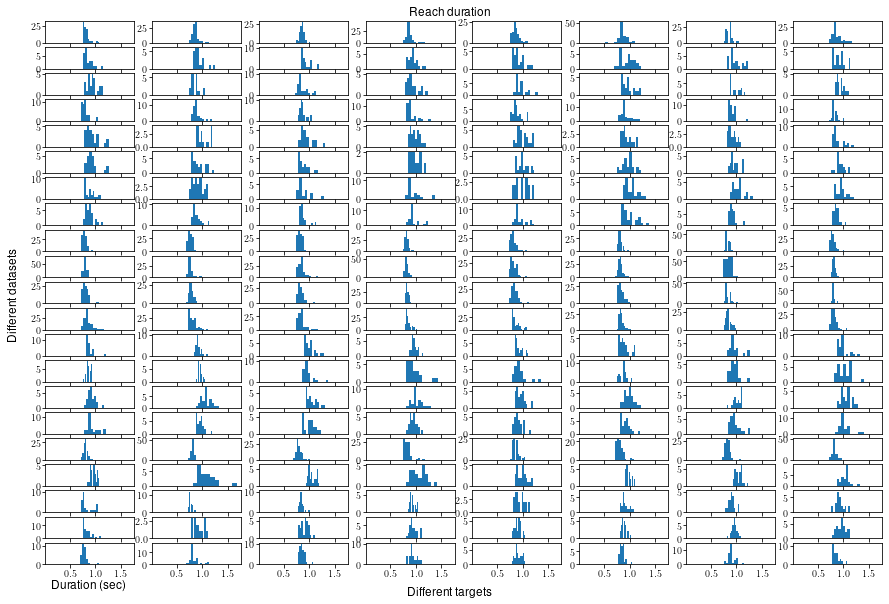

In [5]:
if "__file__" not in dir():

    fig,axes = plt.subplots(len(allDFs_MCx),len(np.unique(df.target_id)),figsize=(15,10), sharex=True)


    for row,df in enumerate(allDFs_MCx):
        a = reach_phase_len(df)
        for col, data in a.items():
            axes[row,col].hist(np.array(data))
    fig.suptitle('Reach duration', y=0.9);
    axes[-1,0].set_xlabel('Duration (sec)')
    fig.supxlabel('Different targets', y=.08)
    fig.supylabel('Different datasets', x=.09)

## Correlate within and across sessions

### WARNING $-$ go to next cell
target matched!!

In [6]:
def warp_within_monkey_corr(allDF:list[pd.DataFrame],):
    within_corrs = {}
    for df in allDF:
        within_corrs[df.session[0]] = []
        targets = np.unique(df.target_id)
        for target in targets:
            df_ = pyal.select_trials(df, df.target_id == target)
            for i, pos1 in enumerate(df_.pos):
                a = pos1[int(df_.idx_movement_on[i]):int(df_.idx_trial_end[i]),:]
                for j, pos2 in enumerate(df_.pos):
                    if j<=i: continue
                    b = pos2[int(df_.idx_movement_on[j]):int(df_.idx_trial_end[j]),:]
                    a_,b_ = dt.warp_time(a,b)
                    r = [pearsonr(aa,bb)[0] for aa,bb in zip(a_.T,b_.T)]
                    within_corrs[df_.session[0]].append(np.mean(np.abs(r)))
    return within_corrs


def warp_across_monkey_corr(allDF:list[pd.DataFrame],):
    across_corrs = {}
    for dfi, df1 in enumerate(allDF):
        targets = np.unique(df1.target_id)
        across_corrs[df1.session[0]]={}
        for dfj, df2 in enumerate(allDF):
            across_corrs[df2.session[0]] = {} if df2.session[0] not in across_corrs.keys() else across_corrs[df2.session[0]]
            if dfj <= dfi: continue
            across_corrs[df1.session[0]][df2.session[0]]=[]
            for target in targets:
                df1_ = pyal.select_trials(df1, df1.target_id == target)
                df2_ = pyal.select_trials(df2, df2.target_id == target)
                for i, pos1 in enumerate(df1_.pos):
                    a = pos1[int(df1_.idx_movement_on[i]):int(df1_.idx_trial_end[i]),:]
                    for j, pos2 in enumerate(df2_.pos):
                        b = pos2[int(df2_.idx_movement_on[j]):int(df2_.idx_trial_end[j]),:]
                        a_,b_ = dt.warp_time(a,b)
                        r = [pearsonr(aa,bb)[0] for aa,bb in zip(a_.T,b_.T)]
                        across_corrs[df1_.session[0]][df2_.session[0]].append(np.mean(np.abs(r)))

        
        # make the across correlations symmetrical!
        for  df2_session, val in across_corrs[df1_.session[0]].items():
            across_corrs[df2_session][df1_.session[0]] = val
    
    return across_corrs

In [ ]:
if "__file__" not in dir():
    within_corrs = warp_within_monkey_corr(allDFs_PMd)
    across_corrs = warp_across_monkey_corr (allDFs_PMd)
    
    fig,axes = plt.subplots(len(allDFs_PMd),len(allDFs_PMd),figsize=(10,10),)

    for i, df1 in enumerate(allDFs_PMd):
        for j, df2 in enumerate(allDFs_PMd):
            if j<=i:
                utility.phantom_axes(axes[i,j])
                continue
            ax = axes[i,j]
            ax.hist(across_corrs[df1.session[0]][df2.session[0]],alpha=.8,color='r',label=r'across $i$ \& $j$')
            ax.hist(within_corrs[df1.session[0]],alpha=.5,color='b',label='within $i$')
            ax.hist(within_corrs[df2.session[0]],alpha=.5,color='b',label='within $j$')
            ax.set_yticks([])
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['left'].set_visible(False)

    [fig.delaxes(ax) for ax in axes[-1,:]]
    axes[0,1].legend(bbox_to_anchor=(0,.5),loc=7)
    axes[-2,-1].set_xlabel(r"Pearson's $r$")
    fig.supylabel('Different sessions', x=.92)


### no warping

trimming instead: not expected much difference as the behaviour is largely consistent, so the durations are similar

In [3]:
def trim_within_monkey_corr(allDF:list[pd.DataFrame], redo = False):
    within_corrs = {}
    for df__ in allDF:
        within_corrs[df__.session[0]] = []
        pathPickle = root / 'monkey-pickles' / f'{df__.session[0]}_within_corr.p'
        if os.path.exists(pathPickle) and not redo:
            with open(pathPickle,"rb") as f:
                result=pickle.load(f)
            within_corrs[df__.session[0]] = result
            continue
        else:
            df = pyal.restrict_to_interval(df__, epoch_fun=defs.exec_epoch)
            targets = np.unique(df.target_id)
            for target in targets:
                df_ = pyal.select_trials(df, df.target_id == target)
                for i, pos1 in enumerate(df_.pos):
                    a = pos1
                    for j, pos2 in enumerate(df_.pos):
                        if j<=i: continue
                        b = pos2
                        r = [pearsonr(aa,bb)[0] for aa,bb in zip(a.T,b.T)]
                        within_corrs[df_.session[0]].append(np.mean(np.abs(r)))
        with open(pathPickle, 'wb') as f:
            pickle.dump(within_corrs[df_.session[0]], f)
            f.close()
    
    return within_corrs


def trim_across_monkey_corr(allDF:list[pd.DataFrame], redo=False):
    across_corrs = {}
    #for each session
    for dfi, df1__ in enumerate(allDF):
        df1 = pyal.restrict_to_interval(df1__, epoch_fun=defs.exec_epoch)
        targets = np.unique(df1.target_id)
        across_corrs[df1.session[0]]={}

        #compare to each session
        for dfj, df2__ in enumerate(allDF):
            #save results in dict
            pathPickle = root / 'monkey-pickles' / f'{df1__.session[0]}_{df2__.session[0]}_across_corr.p'
            if os.path.exists(pathPickle) and not redo:
                with open(pathPickle,"rb") as f:
                    result=pickle.load(f)
                across_corrs[df1__.session[0]][df2__.session[0]] = result
                across_corrs[df2__.session[0]] = {} if df2__.session[0] not in across_corrs.keys() else across_corrs[df2__.session[0]]
                continue
            df2 = pyal.restrict_to_interval(df2__, epoch_fun=defs.exec_epoch)
            across_corrs[df2.session[0]] = {} if df2.session[0] not in across_corrs.keys() else across_corrs[df2.session[0]]
            if dfj <= dfi: continue
            across_corrs[df1.session[0]][df2.session[0]]=[]

            #for each target
            for target in targets:
                df1_ = pyal.select_trials(df1, df1.target_id == target)
                df2_ = pyal.select_trials(df2, df2.target_id == target)
                #correlate pairs of reaches
                for i, pos1 in enumerate(df1_.pos):
                    for j, pos2 in enumerate(df2_.pos):
                        r = [pearsonr(aa,bb)[0] for aa,bb in zip(pos1.T,pos2.T)]
                        across_corrs[df1_.session[0]][df2_.session[0]].append(np.mean(np.abs(r)))
            
            with open(pathPickle, 'wb') as f:
                pickle.dump(across_corrs[df1_.session[0]][df2_.session[0]], f)
                f.close()

        # make the across correlations symmetrical!
        for  df2_session, val in across_corrs[df1__.session[0]].items():
            across_corrs[df2_session][df1__.session[0]] = val

    return across_corrs

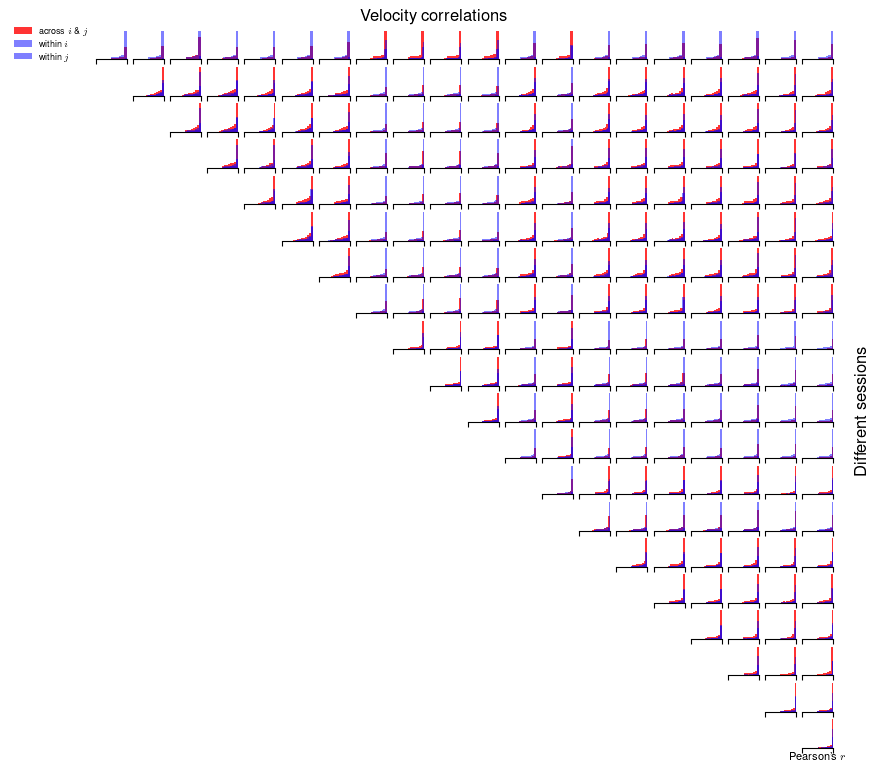

In [5]:
if "__file__" not in dir():
    within_corrs = trim_within_monkey_corr(allDFs_MCx)
    across_corrs = trim_across_monkey_corr (allDFs_MCx)

    fig,axes = plt.subplots(len(allDFs_MCx),len(allDFs_MCx),figsize=(10,10), dpi=100, sharex=True)

    for i, df1 in enumerate(allDFs_MCx):
        for j, df2 in enumerate(allDFs_MCx):
            if j<=i:
                utility.phantom_axes(axes[i,j])
                continue
            ax = axes[i,j]
            ax.hist(across_corrs[df1.session[0]][df2.session[0]],alpha=.8,color='r',label=r'across $i$ \& $j$')
            ax.hist(within_corrs[df1.session[0]],alpha=.5,color='b',label='within $i$')
            ax.hist(within_corrs[df2.session[0]],alpha=.5,color='b',label='within $j$')
            ax.set_yticks([])
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.set_xlim([0,1])
            ax.set_xticks([0,1])

    [fig.delaxes(ax) for ax in axes[-1,:]]
    axes[0,1].legend(bbox_to_anchor=(0,.5),loc=7)
    axes[-2,-1].set_xlabel(r"Pearson's $r$", );
    fig.supylabel('Different sessions', x=.92)
    fig.suptitle('Velocity correlations',y=.9);

# Test Jaco

In [45]:
if "__file__" not in dir():

    allDF = []
    for df in allDFs_MCx:
        if 'J' in df.monkey[0]:
            allDF.append(pyal.restrict_to_interval(df, epoch_fun=defs.exec_epoch))

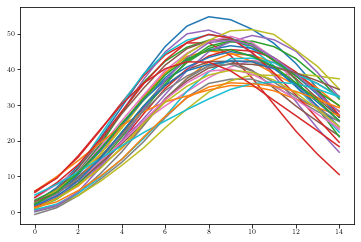

In [46]:
if "__file__" not in dir():

    for data, i in zip(allDF[0].vel,allDF[0].target_id):
        if i == 3:
            plt.plot(data[:,0])